# Solution 4

## FINM 37400 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

# 1 HBS Case: The Information Content of the Yield Curve

# Imports

In [91]:
import pandas as pd
import numpy as np
import datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

import sys
sys.path.insert(0, '../cmds')
from treasury_cmds import *

## 1.1

The Term Spread
* What is the term spread? 
* What is the preferred measure of the term spread in the case?
* What evidence is cited for the term spread's power in predicting recessions?
* Which is more important, the level of the term spread, its month-over-month change, or the level of short rates?

Using the file `yields.xlsx`, calculate the term spread at the end of the sample.
* What does this term spread suggest about economic growth, according to the evidence of Estrella?

> What is the term spread?

The term spread is the difference between long-term and short-term interest rates. It's a measure used to gauge the shape of the yield curve.

> What is the preferred measure of the term spread in the case?

The case emphasizes the term spread as measured by the difference between the 10-year Treasury rate and the three-month Treasury rate.

> What evidence is cited for the term spread's power in predicting recessions?

The case cites the Federal Reserve Bank of New York's work, particularly by Arturo Estrella, showing that the term spread predicts subsequent US real GDP growth with a lead time of about four to six quarters. It has historically been an accurate predictor of US recessions since 1950.

> Which is more important, the level of the term spread, its month-over-month change, or the level of short rates?

The level of the term spread is more important than its month-over-month change or the level of short rates in predicting recessions. The term spread's absolute value provides a clearer indication of future economic conditions.

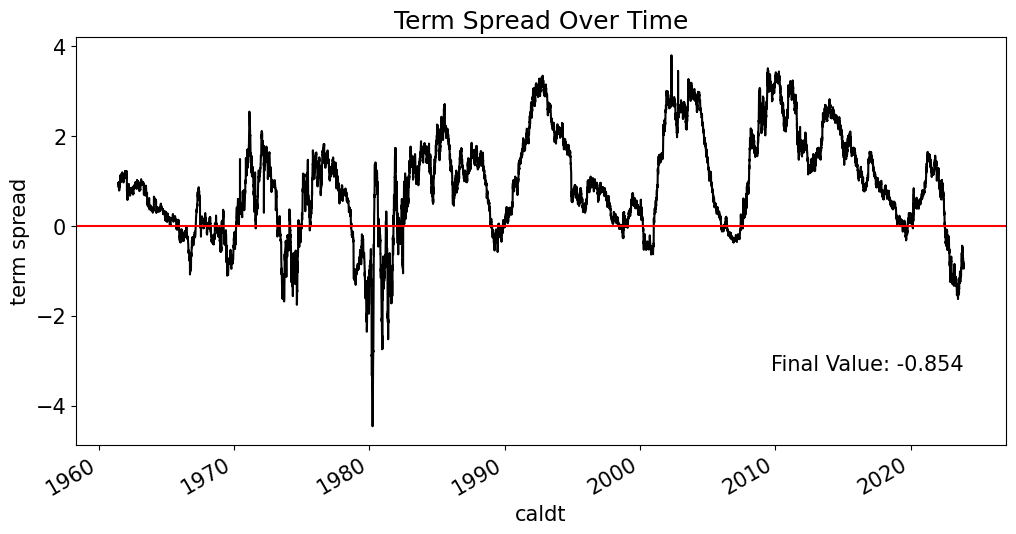

In [92]:
filepath = f'../data/yields.xlsx'
yields = pd.read_excel(filepath, index_col=0, parse_dates=True)

# Calculate the term spread
term_spread = yields[10] - yields[1]
ax = term_spread.plot(color='k')
ax.axhline(0, color='r')

# Add label for final value
final_value = term_spread.iloc[-1]

ax.annotate(f'Final Value: {final_value:.3f}', xy=(term_spread.index[-1], -4), xytext=(term_spread.index[-1], final_value - 2), ha='right', va='top')
ax.set_xlabel('caldt')
ax.set_ylabel('term spread')
ax.set_title('Term Spread Over Time')
plt.show()

Estrella’s evidence suggests if it’s negative (an inverted yield curve), it could indicate an upcoming recession.


## 1.2

Term premia
* What is the term premium? Why is it impossible to get a direct measure of it?
* Explain equations (1) and (2). Why does Sacks think this concept of the term spread complicates the relationship found by Estrella?

> What is the term premium? Why is it impossible to get a direct measure of it?

The term premium is the additional yield that investors require to hold a longer-term bond instead of a series of shorter-term instruments. It compensates for the increased risk (like interest rate risk) of holding bonds with longer maturities. It's challenging to measure directly because it's not observable and must be estimated using financial models.

> Explain equations (1) and (2). Why does Sacks think this concept of the term spread complicates the relationship found by Estrella?

Equation (1): This equation suggests that a 10-year rate can be thought of as the expected average of the next 10 one-year rates plus a term premium.

Equation (2): Shows that the term spread (difference between a 10-year rate and a one-year rate) is an average of expected changes in the short rate, plus the term premium.

Sack argues that the relationship between the term spread and economic outcomes is more complex than Estrella's findings suggest. The term premium component in the yield curve can significantly influence the slope of the yield curve, complicating the direct relationship between the term spread and economic forecasts.


## 1.3

Though this case touches on monetary policy, that is not our focus. Rather, our focus is the degree to which the current shape of the yield curve is predictive of future short-term interest rates.

Suppose the term premium is zero. 
* What does a downward-sloping yield curve predict about future short-term rates? 
* In this case, is it risky to hold long-term bonds or short-term bonds? Is this risk compensated?

Suppose the term premium increases 5 percentage points.
* What would change about your previous answer?

> What does a downward-sloping yield curve predict about future short-term rates? In this case, is it risky to hold long-term bonds or short-term bonds? Is this risk compensated?

If the term premium is zero and the yield curve is downward-sloping, it predicts that future short-term rates will likely decrease. In this scenario, long-term bonds may be riskier due to potential increases in interest rates, but this risk is not compensated since the term premium is zero.

> Suppose the term premium increases 5 percentage points. What would change about your previous answer?

An increase in the term premium would generally lead to a steeper yield curve. In this case, a downward-sloping yield curve would still predict lower short-term rates in the future, but the steepening curve due to the increased term premium might suggest that long-term bonds could become more attractive. The risk associated with holding long-term bonds might be better compensated due to the higher term premium.

***

# 2 Calculating Forwards

Use the treasury issues in `'../data/select_maturities_2023-08-31.xlsx`. 

The selected treasuries are at nearly six-month intervals. Approximate that they mature at perfect 6-month intervals. 

In [93]:
QUOTE_DATE = '2023-08-31'
filepath = f'../data/select_maturities_{QUOTE_DATE}.xlsx'
quotes = pd.read_excel(filepath, index_col=0)
t_date = pd.to_datetime(QUOTE_DATE)

## 2.1 
Bootstrap the discount factor. 

Plot the answer in terms of discount factors and discount rates.

#### Simplification 
Though the time-to-maturity (ttm) is not spaced exactly at 6 months, for the purposes of this problem, you are welcome to approximate that they are spaced at exact 6-month intervals.

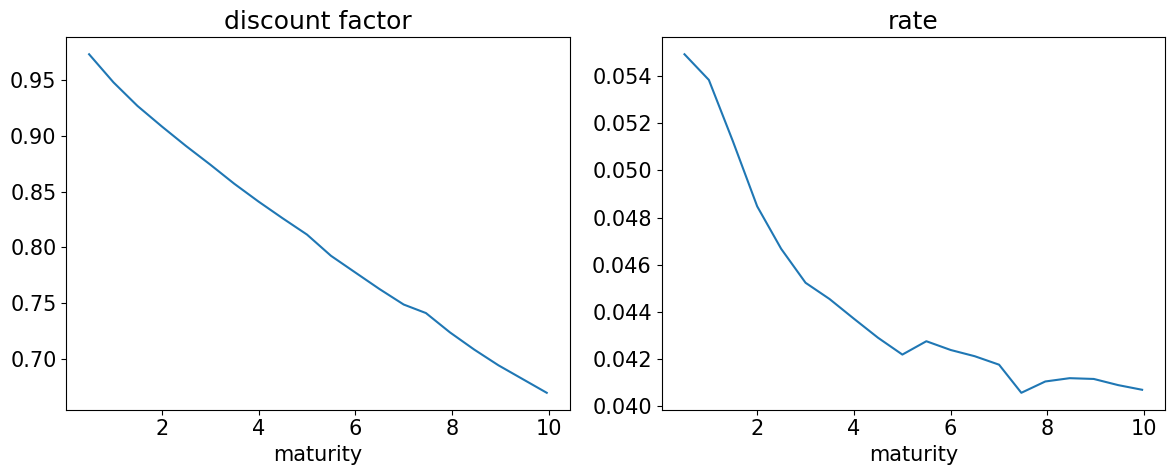

In [94]:
CF = pd.DataFrame(0, index=quotes.index, columns= quotes['maturity date'])
for i in quotes.index:
    coupon_dates = get_coupon_dates(t_date, pd.to_datetime(quotes.loc[i, 'maturity date']))
    if coupon_dates is not None:
        CF.loc[i, coupon_dates] = quotes.loc[i, 'cpn rate'] / 2    
    CF.loc[i,quotes.loc[i, 'maturity date']] += 100

CF = CF.resample('m', axis = 1).sum()
CF.drop(columns=CF.columns[(CF==0).all()], inplace=True)
CF = CF.fillna(0).sort_index(axis=1)


COMPOUNDING = 2
quotes['price'] = (quotes['bid'] + quotes['ask']) / 2 + quotes['accrint']
quotes['maturity'] = get_maturity_delta(quotes['maturity date'], t_date)

spot = pd.DataFrame(np.linalg.solve(CF,quotes['price'].loc[CF.index]), index=CF.index, columns=['discount factor'])
spot.insert(0,'maturity',quotes['maturity'])
spot = spot.reset_index().set_index('maturity')
spot['rate'] = discount_to_intrate(spot['discount factor'], spot.index,n_compound=COMPOUNDING)

#Plot discount factor and rate
fig, ax = plt.subplots(1,2,figsize=(12,5))
spot['discount factor'].plot(ax=ax[0],title='discount factor')
spot['rate'].plot(ax=ax[1],title='rate')
plt.tight_layout()
plt.show()


## 2.2
Calculate and plot the forward discount factors from $T$ to $T+0.5$, ranging $T$ from 0.5 through 9.5.



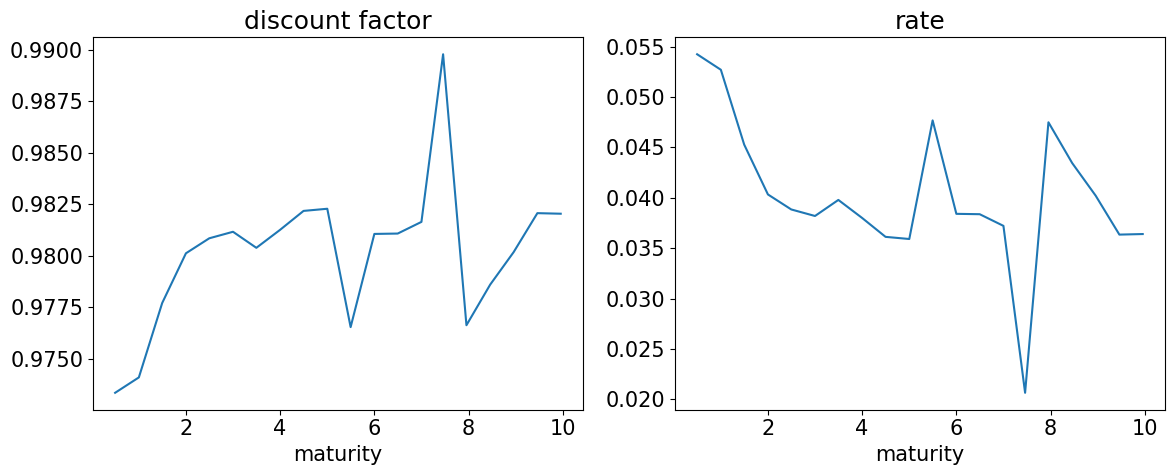

In [95]:
forward = pd.DataFrame(spot['discount factor']/spot['discount factor'].shift(),index=spot.index, columns=['discount factor'])
forward['discount factor'].iloc[0] = spot['discount factor'].iloc[0]
forward['rate'] = -np.log(forward['discount factor']) / forward.index.to_series().diff().mean()
fig, ax = plt.subplots(1,2,figsize=(12,5))
forward['discount factor'].plot(ax=ax[0],title='discount factor')
forward['rate'].plot(ax=ax[1],title='rate')
plt.tight_layout()
plt.show()


## 2.3
Use the forward discount factors to calculate the `semiannually` compounded forward **rates**.

Plot the curve.

Also report the forward-rate values from 

* $T_1=0.5$ to $T_2=1$.
* $T_1=9.5$ to $T_2=10$.


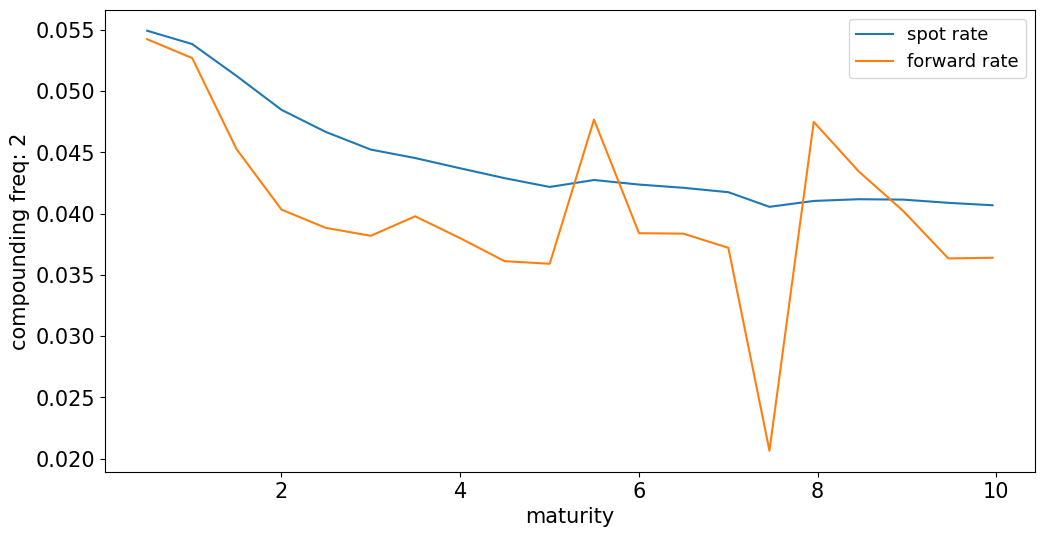

The Forward Rate at 0.5 to 1 is 5.27%
The Forward Rate at 9.5 to 10 is 3.64%


In [96]:
fig, ax = plt.subplots()
spot['rate'].plot(ax=ax)
forward['rate'].plot(ax=ax)
plt.legend(['spot rate','forward rate'])
plt.ylabel(f'compounding freq: {COMPOUNDING}')
plt.show()
T2list = [1,10]
for T2 in T2list:
    forwardrate = forward['rate'].iloc[int(T2*2)-1]
    print(f'The Forward Rate at {T2-.5} to {T2} is {forwardrate:.2%}')


## 2.4
Explain how an FRA between $T_1$ and $T_2$ would function. 

The FRA would have contract parameters for

- Notional
- T1 and T2 dates
- floating rate index paid to the counterparty

Given these parameters, counterparties would agree upon forward rate for exchange of payment:
\begin{align*}
N\kappa[r_n(T_1,T_2)-f_n(t,T_1,T_2)]
\end{align*}
where $\kappa$ is the fraction of the year covered by $T_2-T_1$ and $N$ is the notional amt.

We calculated this fixed forward rate above, assuming $T_2 = T_1 + .5$



***